# Pre-processing

## Import Libs

In [0]:
%matplotlib inline

import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy import mean

import warnings
warnings.filterwarnings('ignore')

## Upload data

In [0]:
from google.colab import files
uploaded = files.upload()

Saving fifa.csv to fifa.csv
Saving crypto.csv to crypto.csv
Saving black_friday.csv to black_friday.csv
Saving athletes.csv to athletes.csv


## Common used functions

### Best Fit Distribution function
Code by tmthydvnprt from his answer at https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python

This approach is based on computing Sum Square Error (SSE) for each distribution in DISTRIBUTIONS and returns a distributions with the least SSE.

Important: this only works for continuous distributions since discrete distributions don't implement fit() method. Therefore, the discrete distributions included in DISTRIBUTIONS should raise an exception, handled by the try block.

In [0]:
# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [
        st.uniform,st.norm,st.gamma,st.expon,st.chi2,st.beta,st.lognorm,st.weibull_min,st.weibull_max,st.f,st.t,
        st.binom, st.multinomial, st.hypergeom, st.nbinom, st.geom, st.poisson
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax, label=distribution.name, legend=True)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

### Make PDF
Create a Probability Distribution Function (PDF) which represents the given distribution and parameters.

In [0]:
def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Dataset 1: FIFA

## Read dataset

In [0]:
data_frame_1 = pd.read_csv('fifa.csv')

## Data visualization

### Histogram

Text(0.5, 0, 'Age')

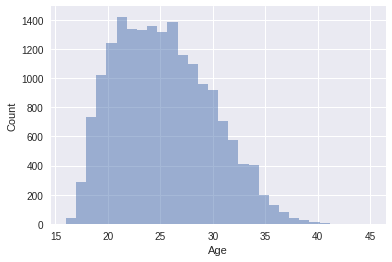

In [53]:
# Display Age Histogram
age_histogram = data_frame_1['Age'].hist(bins=(data_frame_1['Age'].max() - data_frame_1['Age'].min() + 1),
                                         alpha=0.5)

# Display params
plt.ylabel('Count')
plt.xlabel('Age')

### Boxplot

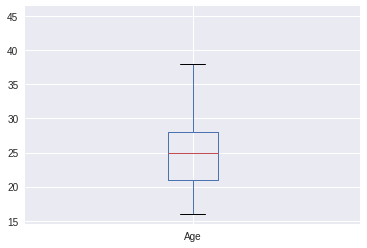

In [54]:
# Display Age boxplot
age_boxplot = data_frame_1.boxplot(column='Age')

## Statistical description

In [55]:
pd.concat([pd.DataFrame(data_frame_1.min(), columns = ["Min"]).T, 
          pd.DataFrame(data_frame_1.max(), columns = ["Max"]).T,
          pd.DataFrame(data_frame_1.mean(), columns = ["Mean"]).T,
          data_frame_1.mode(axis=0).rename(index={0 : "Mode"}),
          pd.DataFrame(data_frame_1.median(), columns = ["Median"]).T,
          pd.DataFrame(data_frame_1.var(), columns = ["Variance"]).T,
          pd.DataFrame(data_frame_1.std(), columns = ["Std_dev"]).T,
          pd.DataFrame(data_frame_1.skew(), columns = ["Skewness"]).T,
          pd.DataFrame(data_frame_1.kurt(), columns = ["Kurtosis"]).T])

Age           Name  Nationality
Min                 16       A. Abang  Afghanistan
Max                 45  Óscar Whalley     Zimbabwe
Mean      2.512221E+01            NaN          NaN
Mode                21   J. Rodríguez      England
Median    2.500000E+01            NaN          NaN
Variance  2.180836E+01            NaN          NaN
Std_dev   4.669943E+00            NaN          NaN
Skewness  3.917641E-01            NaN          NaN
Kurtosis -4.595136E-01            NaN          NaN

## Best-fit Distribution

Text(0, 0.5, 'Frequency')

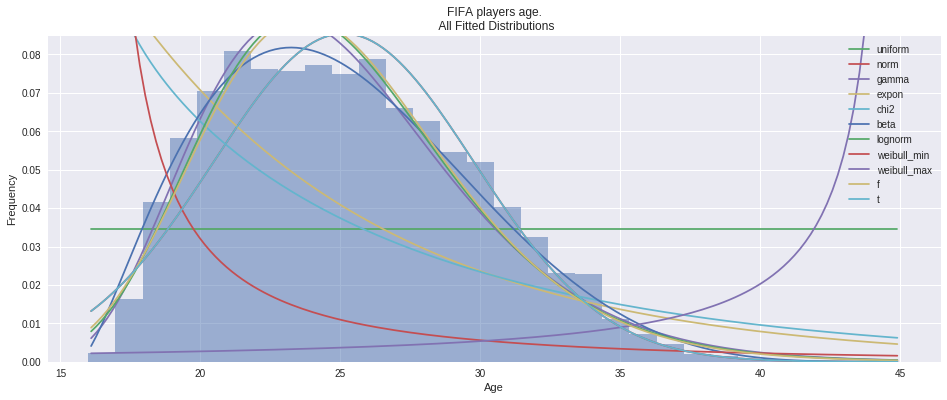

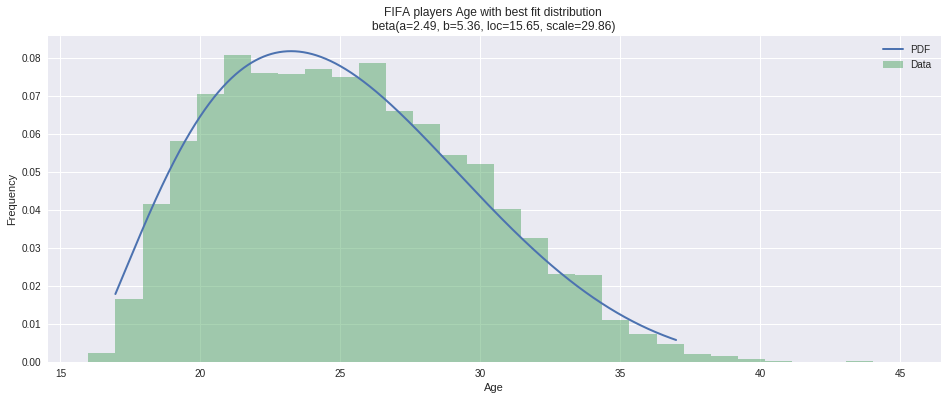

In [56]:
# Get data from datasets
data = data_frame_1['Age']

# Set constants
data_bins = data.max()-data.min()+1
fig_size = (16,6)

# Plot normalized data for comparison
plt.figure(figsize=fig_size)
ax = data.plot(kind='hist', bins=data_bins, normed=True, alpha=0.5)
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data, data_bins*5, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'FIFA players age.\n All Fitted Distributions')
ax.set_xlabel(u'Age')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=fig_size)
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=data_bins, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'FIFA players Age with best fit distribution \n' + dist_str)
ax.set_xlabel(u'Age')
ax.set_ylabel('Frequency')

In [0]:
best_distribution = getattr(st, best_fit_name)

a = best_fit_params[-4]
b = best_fit_params[-3]
loc = best_fit_params[-2]
scale = best_fit_params[-1]

## Questions

### a. Jika terdapat 1000 pemain bola baru yang ditambahkan oleh Tsubasa, tentukan ekspektasi umur pemain bola yang:

In [0]:
n = 1000

#### i. Berumur kurang dari 22 tahun

In [59]:
xi = 22

Exi = n * best_distribution.cdf(xi, a, b, loc, scale)
print('Expected: ' + str(Exi))

roundExi = np.floor(Exi)
print('Rounded: ' + str(roundExi))

Expected: 287.29490958143407
Rounded: 287.0


#### ii. Berumur lebih dari 40 tahun

In [60]:
xii = 40

Exii = n * best_distribution.sf(xii, a, b, loc, scale)
print('Expected: ' + str(Exii))

roundExii = np.floor(Exii)
print('Rounded: ' + str(roundExii))

Expected: 1.1368509825689932
Rounded: 1.0


# Dataset 3: Black Friday

## Read Dataset 3

In [0]:
df1 = pd.read_csv('black_friday.csv', header = None, usecols = [0], names = ["spent_dollars"])

## Description of Dataset 3

### Histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe1e59900f0>]],
      dtype=object)

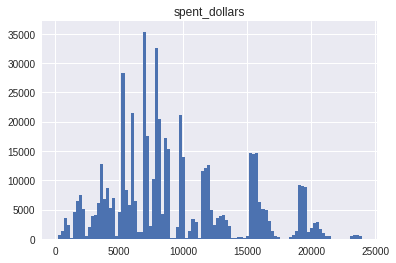

In [62]:
# Display Histogram

df1.hist(bins=100)

###Box Plot

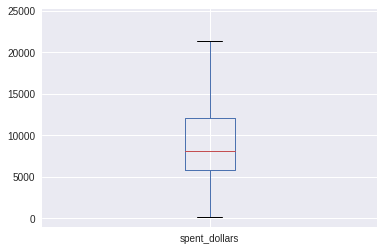

In [63]:
# Display Boxplot
df1.boxplot()

### Minimum, Maximum, Mean, Mode, Median, Variance, Standard Deviation, Skewness, and Kurtosis

In [64]:
# Show with 5 digits after decimal
pd.set_option('float_format', '{:.5f}'.format)

pd.concat([pd.DataFrame(df1.min(), columns = ["Min"]).T, 
          pd.DataFrame(df1.max(), columns = ["Max"]).T,
          pd.DataFrame(df1.mean(), columns = ["Mean"]).T,
          df1.mode(axis=0).rename(index={0 : "Mode"}),
          pd.DataFrame(df1.median(), columns = ["Median"]).T,
          pd.DataFrame(df1.var(), columns = ["Variance"]).T,
          pd.DataFrame(df1.std(), columns = ["Std_dev"]).T,
          pd.DataFrame(df1.skew(), columns = ["Skewness"]).T,
          pd.DataFrame(df1.kurt(), columns = ["Kurtosis"]).T])

spent_dollars
Min           185.00000
Max         23961.00000
Mean         9333.85985
Mode         6855.00000
Median       8062.00000
Variance 24810581.48601
Std_dev      4981.02213
Skewness        0.62428
Kurtosis       -0.34312

## Fitting a Probability Distribution to Data

Text(0, 0.5, 'Frequency')

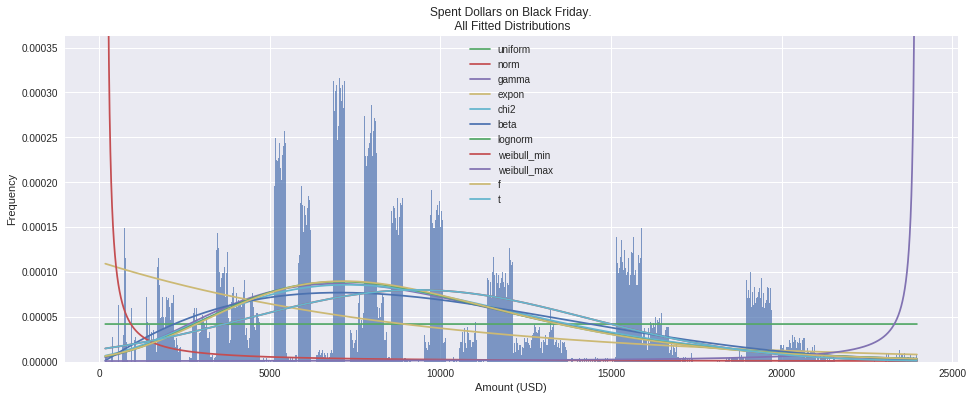

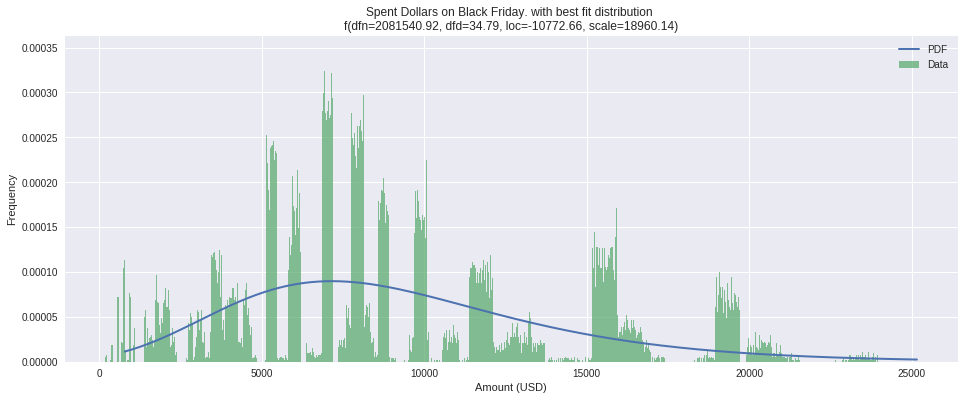

In [65]:
# Get data from datasets
data = df1['spent_dollars']

# Set constants
data_bins = data.max()-data.min()+1
fig_size = (16,6)

# Plot for comparison
plt.figure(figsize=fig_size)
ax = data.plot(kind='hist', bins=data_bins, normed=True, alpha=0.7)
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data, data_bins*5, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'Spent Dollars on Black Friday.\n All Fitted Distributions')
ax.set_xlabel(u'Amount (USD)')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=fig_size)
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=data_bins, normed=True, alpha=0.7, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'Spent Dollars on Black Friday. with best fit distribution \n' + dist_str)
ax.set_xlabel(u'Amount (USD)')
ax.set_ylabel('Frequency')

In [0]:
best_distribution = getattr(st, best_fit_name)

dfn = best_fit_params[-4]
dfd = best_fit_params[-3]
loc = best_fit_params[-2]
scale = best_fit_params[-1]

## Questions

###Jika terdapat 250 orang pembeli baru yang mengikuti Black Friday, tentukan ekspektasi jumlah orang yang

In [0]:
n = 250

####Miskin (total pembelian < 1000 dolar)

In [68]:
expPeople = n * best_distribution.cdf(1000, loc, scale)
print('Expected: ' + str(expPeople))

people = np.floor(expPeople)
print('Rounded: ' + str(people))

Expected: nan
Rounded: nan


####Kaya (total pembelian > 10000 dolar)

In [69]:
expPeople = n * best_distribution.sf(10000, loc, scale)
print('Expected: ' + str(expPeople))

people = np.floor(expPeople)
print('Rounded: ' + str(people))

Expected: nan
Rounded: nan


####Crazy Rich (total pembelian > 20000 dolar)

In [70]:
expPeople = n * best_distribution.sf(20000, loc, scale)
print('Expected: ' + str(expPeople))

people = np.floor(expPeople)
print('Rounded: ' + str(people))

Expected: nan
Rounded: nan


###Jika terdapat 1000 orang pembeli baru yang mengikuti Black Friday, tentukan ekspektasi jumlah orang yang sebenarnya pengeluarannya sama, seperti membeli:

In [0]:
n = 1000

####Galaxy Fold (total pembelian di antara 1980-2000 dolar inklusif)

In [72]:
expPeople =  n*(best_distribution.cdf(2000, loc, scale) -  best_distribution.cdf(1980, loc, scale))
print('Expected: ' + str(expPeople))

people = np.floor(expPeople)
print('Rounded: ' + str(people))

Expected: nan
Rounded: nan


####Macbook Pro 2018 Touch Bar 256GB + iPhone XR + AirPods 2 (Total pembelian di antara 2707-2987 dolar inklusif)

In [73]:
expPeople =  n*(best_distribution.cdf(2707, loc, scale) -  best_distribution.cdf(2987, loc, scale))
print('Expected: ' + str(expPeople))

people = np.floor(expPeople)
print('Rounded: ' + str(people))

Expected: nan
Rounded: nan


# Dataset 4: Cryptocurrency

## Read dataset

In [0]:
data_frame_4 = pd.read_csv('crypto.csv', header = None, usecols = [0], names = ["crypto_price"])

## Data visualization

### Histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe1c8417da0>]],
      dtype=object)

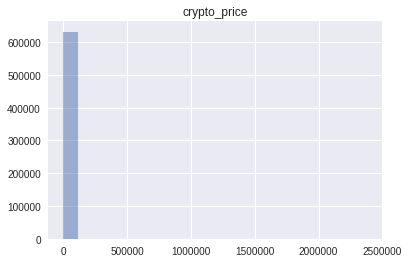

In [75]:
# Display price Histogram
data_frame_4.hist(bins=20, alpha=0.5)

### Boxplot

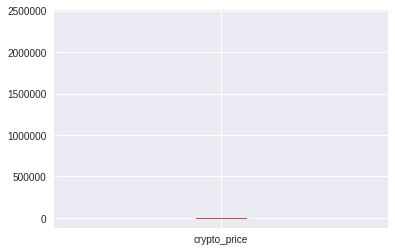

In [76]:
# Display price boxplot
data_frame_4.boxplot()

## Statistical description

In [77]:
# Show with 5 digits after decimal
pd.set_option('float_format', '{:E}'.format)

pd.concat([pd.DataFrame(data_frame_4.min(), columns = ["Min"]).T, 
          pd.DataFrame(data_frame_4.max(), columns = ["Max"]).T,
          pd.DataFrame(data_frame_4.mean(), columns = ["Mean"]).T,
          data_frame_4.mode(axis=0).rename(index={0 : "Mode"}),
          pd.DataFrame(data_frame_4.median(), columns = ["Median"]).T,
          pd.DataFrame(data_frame_4.var(), columns = ["Variance"]).T,
          pd.DataFrame(data_frame_4.std(), columns = ["Std_dev"]).T,
          pd.DataFrame(data_frame_4.skew(), columns = ["Skewness"]).T,
          pd.DataFrame(data_frame_4.kurt(), columns = ["Kurtosis"]).T])

crypto_price
Min       2.925000E-09
Max       2.383502E+06
Mean      2.030181E+02
Mode      2.000000E-06
Median    9.733500E-03
Variance  7.532042E+07
Std_dev   8.678734E+03
Skewness  1.182396E+02
Kurtosis  2.229747E+04

## Best-fit Distribution

Text(0, 0.5, 'Frequency')

<Figure size 1152x432 with 0 Axes>

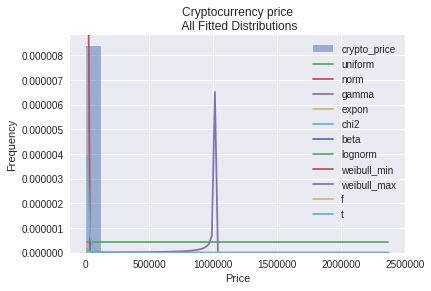

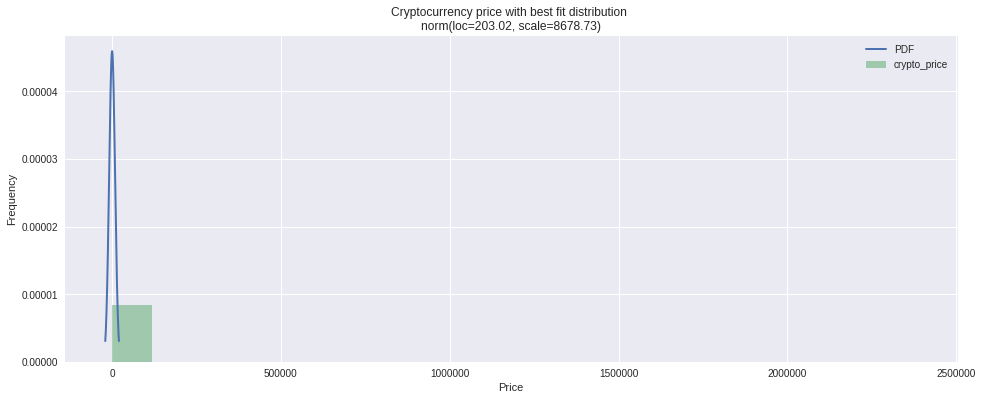

In [78]:
# Get data from datasets
data = data_frame_4

# Set constants
data_bins = 20
fig_size = (16,6)

# Plot normalized data for comparison
plt.figure(figsize=fig_size)
ax = data.plot(kind='hist', bins=data_bins, normed=True, alpha=0.5)
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data, data_bins*5, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'Cryptocurrency price\n All Fitted Distributions')
ax.set_xlabel(u'Price')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=fig_size)
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=data_bins, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'Cryptocurrency price with best fit distribution \n' + dist_str)
ax.set_xlabel(u'Price')
ax.set_ylabel('Frequency')

In [0]:
best_distribution = getattr(st, best_fit_name)

loc = best_fit_params[-2]
scale = best_fit_params[-1]

## Questions

### a. Apabila hari ini terdapat 1000 data harga cryptocurrency baru, tentukan ekspektasi jumlah cryptocurrency yang nilainya

In [0]:
n = 1000

#### i. kurang dari 0.177013

In [81]:
xai = 0.177013

Exai = n * best_distribution.cdf(xai, loc, scale)
print('Expected: ' + str(Exai))

roundExai = np.floor(Exai)
print('Rounded: ' + str(roundExai))

Expected: 490.6766809727818
Rounded: 490.0


#### ii. lebih dari 177.013

In [82]:
xaii = 177.013

Exaii = n * best_distribution.sf(xaii, loc, scale)
print('Expected: ' + str(Exaii))

roundExaii = np.floor(Exaii)
print('Rounded: ' + str(roundExaii))

Expected: 501.1953984736301
Rounded: 501.0


### b. Jika suatu hari terdapat sebuah cryptocurrency baru, tentukan peluang cryptocurrency tersebut bernilai

#### i. lebih dari 0.013

In [83]:
xbi = 0.013

probbi = best_distribution.sf(xbi, loc, scale)	
print('Probability: ' + str(probbi))

Probability: 0.509330856289256


#### ii. kurang dari 17.7

In [84]:
xbii = 17.7

probbii = best_distribution.cdf(xbii, loc, scale)	
print('Probability: ' + str(probbii))

Probability: 0.4914819732393939


#Dataset 5: Athletes

In [0]:
df5 = pd.read_csv("athletes.csv")

## Description of Dataset 5

### Histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe1ca3b57b8>]],
      dtype=object)

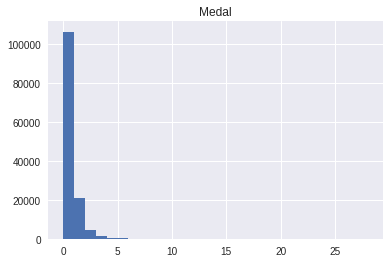

In [86]:
# Display Histogram
df5.hist(bins=28)

####Boxplot

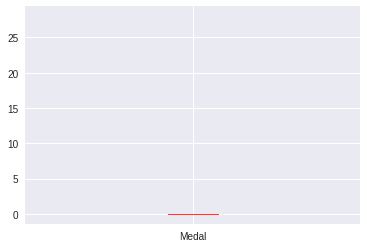

In [87]:
# Display price boxplot
df5.boxplot()

####Min, Max, Mean, Mode, Median, Variance, Standard Deviation, Skewness, Kurtosis

In [88]:
# Show with 5 digits after decimal
pd.set_option('float_format', '{:E}'.format)

# Min Max on string determined alphanumerically
pd.concat([pd.DataFrame(df5.min(numeric_only=True), columns = ["Min"]).T, 
          pd.DataFrame(df5.max(numeric_only=True), columns = ["Max"]).T,
          pd.DataFrame(df5.mean(numeric_only=True), columns = ["Mean"]).T,
          df5.mode(axis=0, numeric_only=True).rename(index={0 : "Mode"}),
          pd.DataFrame(df5.median(numeric_only=True), columns = ["Median"]).T,
          pd.DataFrame(df5.var(numeric_only=True), columns = ["Variance"]).T,
          pd.DataFrame(df5.std(numeric_only=True), columns = ["Std_dev"]).T,
          pd.DataFrame(df5.skew(numeric_only=True), columns = ["Skewness"]).T,
          pd.DataFrame(df5.kurt(numeric_only=True), columns = ["Kurtosis"]).T])

Medal
Min      0.000000E+00
Max      2.800000E+01
Mean     2.952773E-01
Mode     0.000000E+00
Median   0.000000E+00
Variance 5.252133E-01
Std_dev  7.247160E-01
Skewness 4.819999E+00
Kurtosis 5.156253E+01

### Best Fit Distribution

Text(0, 0.5, 'Frequency')

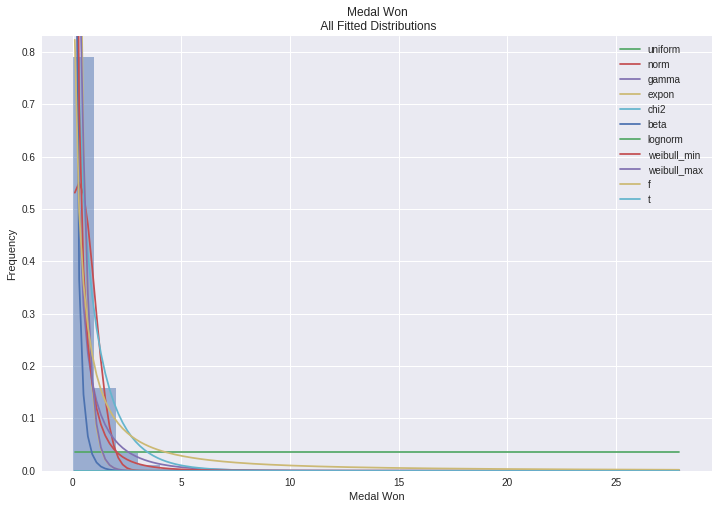

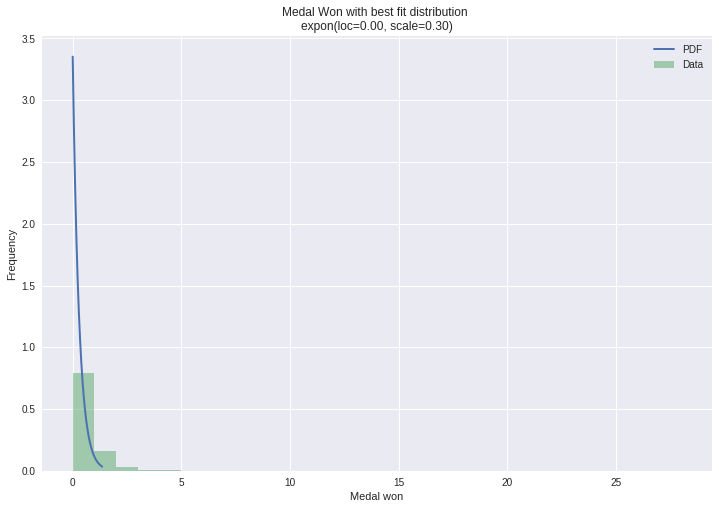

In [89]:
# Get data from datasets
data = df5['Medal']

# Set constants
data_bins = 28
fig_size = (12,8)

# Plot normalized data for comparison
plt.figure(figsize=fig_size)
ax = data.plot(kind='hist', bins=data_bins, normed=True, alpha=0.5)
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data, data_bins*5, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'Medal Won\n All Fitted Distributions')
ax.set_xlabel(u'Medal Won')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=fig_size)
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=data_bins, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'Medal Won with best fit distribution \n' + dist_str)
ax.set_xlabel(u'Medal won')
ax.set_ylabel('Frequency')

In [0]:
best_distribution = getattr(st, best_fit_name)

loc = best_fit_params[-2]
scale = best_fit_params[-1]

## Questions

### Peluang Y Meraih

#### Tepat 0 Medali

In [91]:
medalProb = best_distribution.cdf(1, loc, scale)
print('Probability: ' + str(medalProb))

Probability: 0.9661781272508008


#### Lebih dari 10 Medali

In [92]:
medalProb = best_distribution.sf(10, loc, scale)
print('Probability: ' + str(medalProb))

Probability: 1.9587387370793326e-15


####Tepat 3 Medali

In [93]:
medalProb = best_distribution.pdf(3, loc, scale)
print('Probability: ' + str(medalProb))

Probability: 0.00013102765155568406


####1 atau 5 Medali

In [94]:
medalProb = best_distribution.pdf(1, loc, scale) + best_distribution.pdf(5, loc, scale)
print('Probability: ' + str(medalProb))

Probability: 0.11454291280819733


### Confidence Interval of 95%

In [95]:
best_distribution.interval(0.95, loc=loc, scale=scale)

(0.007475772873644558, 1.089242203524168)